In [2]:
import yaml
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from tri_ct_tools.convert.geometry import cate_to_astra, plot_full_geom, calc_distances
from tri_ct_tools.preprocess.beam_hardening import BHC, beam_hardening_coefficients
from tri_ct_tools.image.reader import singlecam_mean

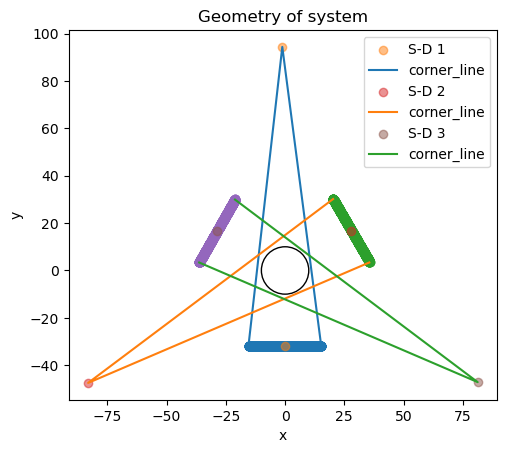

Plotted geometry of system with succes


In [8]:
input_file = Path("../inputs/beam_hardening_corrections.yaml")
with open(input_file) as bhc_yaml:
    bhc_input = yaml.safe_load(bhc_yaml)

det = bhc_input['det']
# path to geometry
geom_path = Path(bhc_input['geom_path'])
# framerange = [bhc_input['framerange']['start'], bhc_input['framerange']['stop']]
img_shape = (det['cols'], det['rows'])
ROI = bhc_input['ROI']
cameras = bhc_input['cameras']

# If the geom path points to a file from the bhc optimization, it is not
# cate-like, and can be loaded in a simplified manner
if geom_path.name == "bhc_optimized_geom.npy":
    geoms_all_cams = np.load(geom_path)
else:
    geoms_all_cams = cate_to_astra(path=geom_path, det=det)

plot_full_geom(geoms_all_cams, det)

Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Full_150kV_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Empty_150kV_22Hz\camera 1
original:  y = 0.19.x
offsetted: y = 0.20.x + -0.05
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Full_150kV_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Empty_150kV_22Hz\camera 2
original:  y = 0.20.x
offsetted: y = 0.19.x + 0.06
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Full_150kV_22Hz\camera 3
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik\03_scattercorrected\300x1500Crop_Empty_150kV_22Hz\camera 3
original:  y = 0.19.x
offsetted: y = 0.20.x + -0.05


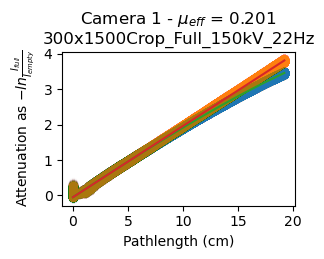

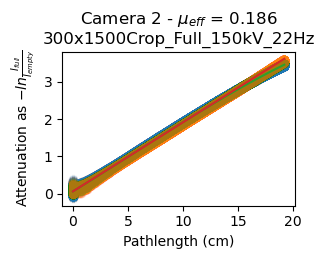

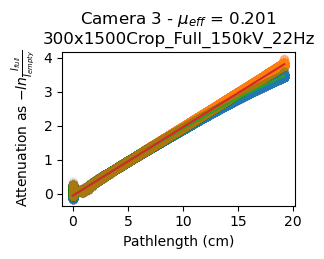

In [33]:

img_path_base = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-07-07 Rik')
startline = 610
ROI = [70, 280]

for cam in cameras:
    path_full = img_path_base / f'03_scattercorrected/300x1500Crop_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'03_scattercorrected/300x1500Crop_Empty_150kV_22Hz/camera {cam+1}'
    img_full = singlecam_mean(path_full, framerange, img_shape)
    img_empty = singlecam_mean(path_empty, framerange, img_shape)
    d, _ = calc_distances(geoms_all_cams, cam, det)
    # img_meas = singlecam_mean(meas_path_cam, framerange, img_shape)
    
    # As we are interested in the fit of the part with no internals, focus there
    img_full = img_full[ROI[0]:ROI[1], :]
    img_empty = img_empty[ROI[0]:ROI[1], :]
    d = d[startline + ROI[0] : startline + ROI[1], :]

    coeff, mu_eff, offset = beam_hardening_coefficients(d, img_full, img_empty)

    # Perform beam hardening correction
    img_full_BHC = BHC(img_full, img_empty, coeff, mu_eff, offset)
    img_empty_BHC = BHC(img_empty, img_empty, coeff, mu_eff, offset)
    rel_intensity_BHC = (img_full_BHC / img_empty_BHC).flatten()
    mask_BHC = rel_intensity_BHC > 0
    rel_intensity_log_BHC = -np.log(rel_intensity_BHC[mask_BHC])
    
    rel_intensity_BH = (img_full / img_empty).flatten()
    mask_BH = rel_intensity_BH > 0
    rel_intensity_log_BH = -np.log(rel_intensity_BH[mask_BH])

    d = d.flatten()
    # Plot the results
    d_vals = np.linspace(0, d.max(), 100)
    p_fit = np.polyval(coeff, d_vals)

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.plot(d[mask_BH], rel_intensity_log_BH, 'o', alpha=0.01, label='data')
    ax.plot(d[mask_BHC], rel_intensity_log_BHC, 'o', alpha=0.01, label='data-BHC')
    ax.plot(d_vals, p_fit, label='polyfit')
    ax.plot(d_vals, d_vals*mu_eff + offset, label='constant attenuation')
    ax.set_title(
        f"Camera {cam+1}"
        R" - $\mu_{eff}$ = "
        f"{mu_eff:.3f}\n"
        f"{path_full.parent.name}"
    )
    ax.set_ylabel(r"Attenuation as $-ln\frac{I_{full}}{I_{empty}}$")
    ax.set_xlabel("Pathlength (cm)")
    # ax.legend()


Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Full_150kV_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Empty_150kV_22Hz\camera 1
original:  y = 0.18.x
offsetted: y = 0.19.x + -0.06
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Full_150kV_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Empty_150kV_22Hz\camera 2


C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:146: RuntimeWarning: invalid value encountered in divide
  rel_intensity = img_full / img_empty
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:18: RuntimeWarning: invalid value encountered in divide
  lnII = -np.log(I_BH/I_empty)
C:\Users\rikvolger\AppData\Local\Temp\ipykernel_30216\3231282033.py:27: RuntimeWarning: invalid value encountered in divide
  rel_intensity_BH = (img_full / img_empty).flatten()


original:  y = 0.19.x
offsetted: y = 0.18.x + 0.05
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Full_150kV_22Hz\camera 3
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Empty_150kV_22Hz\camera 3
original:  y = 0.18.x
offsetted: y = 0.19.x + -0.05


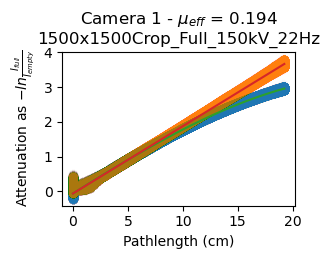

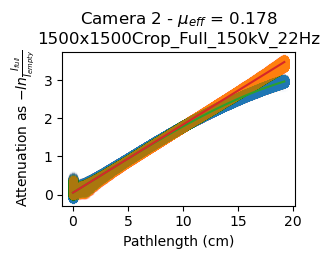

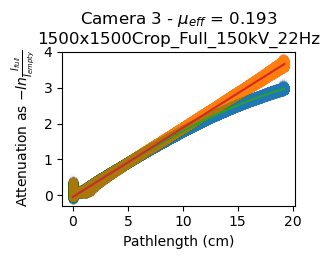

In [34]:
img_path_base = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik')
startline = 0
ROI = [450, 1100]

for cam in cameras:
    path_full = img_path_base / f'03_scattercorrected/1500x1500Crop_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'03_scattercorrected/1500x1500Crop_Empty_150kV_22Hz/camera {cam+1}'
    img_full = singlecam_mean(path_full, framerange, img_shape)
    img_empty = singlecam_mean(path_empty, framerange, img_shape)
    d, _ = calc_distances(geoms_all_cams, cam, det)
    # img_meas = singlecam_mean(meas_path_cam, framerange, img_shape)
    
    # As we are interested in the fit of the part with no internals, focus there
    img_full = img_full[ROI[0]:ROI[1], :]
    img_empty = img_empty[ROI[0]:ROI[1], :]
    d = d[startline + ROI[0] : startline + ROI[1], :]

    coeff, mu_eff, offset = beam_hardening_coefficients(d, img_full, img_empty)

    # Perform beam hardening correction
    img_full_BHC = BHC(img_full, img_empty, coeff, mu_eff, offset)
    img_empty_BHC = BHC(img_empty, img_empty, coeff, mu_eff, offset)
    rel_intensity_BHC = (img_full_BHC / img_empty_BHC).flatten()
    mask_BHC = rel_intensity_BHC > 0
    rel_intensity_log_BHC = -np.log(rel_intensity_BHC[mask_BHC])
    
    rel_intensity_BH = (img_full / img_empty).flatten()
    mask_BH = rel_intensity_BH > 0
    rel_intensity_log_BH = -np.log(rel_intensity_BH[mask_BH])

    d = d.flatten()
    # Plot the results
    d_vals = np.linspace(0, d.max(), 100)
    p_fit = np.polyval(coeff, d_vals)

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.plot(d[mask_BH], rel_intensity_log_BH, 'o', alpha=0.01, label='data')
    ax.plot(d[mask_BHC], rel_intensity_log_BHC, 'o', alpha=0.01, label='data-BHC')
    ax.plot(d_vals, p_fit, label='polyfit')
    ax.plot(d_vals, d_vals*mu_eff + offset, label='constant attenuation')
    ax.set_title(
        f"Camera {cam+1}"
        R" - $\mu_{eff}$ = "
        f"{mu_eff:.3f}\n"
        f"{path_full.parent.name}"
    )
    ax.set_ylabel(r"Attenuation as $-ln\frac{I_{full}}{I_{empty}}$")
    ax.set_xlabel("Pathlength (cm)")
    # ax.legend()

Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Full_150kV_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Empty_150kV_22Hz\camera 1
original:  y = 0.17.x
offsetted: y = 0.18.x + -0.05
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Full_150kV_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Empty_150kV_22Hz\camera 2
original:  y = 0.18.x
offsetted: y = 0.17.x + 0.03


C:\Users\rikvolger\AppData\Local\Temp\ipykernel_30216\847634763.py:27: RuntimeWarning: invalid value encountered in divide
  rel_intensity_BH = (img_full / img_empty).flatten()


Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Full_150kV_22Hz\camera 3
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik\03_scattercorrected\NoCrop_Empty_150kV_22Hz\camera 3
original:  y = 0.17.x
offsetted: y = 0.19.x + -0.07


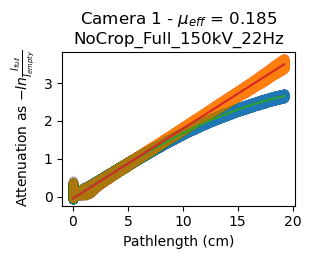

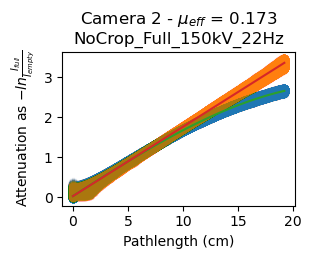

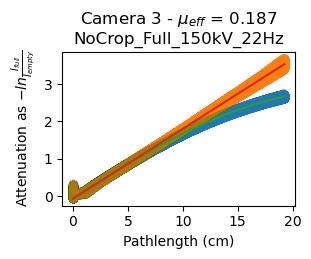

In [35]:
img_path_base = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-19 Rik')
startline = 0
ROI = [450, 1100]

for cam in cameras:
    path_full = img_path_base / f'03_scattercorrected/NoCrop_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'03_scattercorrected/NoCrop_Empty_150kV_22Hz/camera {cam+1}'
    img_full = singlecam_mean(path_full, framerange, img_shape)
    img_empty = singlecam_mean(path_empty, framerange, img_shape)
    d, _ = calc_distances(geoms_all_cams, cam, det)
    # img_meas = singlecam_mean(meas_path_cam, framerange, img_shape)
    
    # As we are interested in the fit of the part with no internals, focus there
    img_full = img_full[ROI[0]:ROI[1], :]
    img_empty = img_empty[ROI[0]:ROI[1], :]
    d = d[startline + ROI[0] : startline + ROI[1], :]

    coeff, mu_eff, offset = beam_hardening_coefficients(d, img_full, img_empty)

    # Perform beam hardening correction
    img_full_BHC = BHC(img_full, img_empty, coeff, mu_eff, offset)
    img_empty_BHC = BHC(img_empty, img_empty, coeff, mu_eff, offset)
    rel_intensity_BHC = (img_full_BHC / img_empty_BHC).flatten()
    mask_BHC = rel_intensity_BHC > 0
    rel_intensity_log_BHC = -np.log(rel_intensity_BHC[mask_BHC])
    
    rel_intensity_BH = (img_full / img_empty).flatten()
    mask_BH = rel_intensity_BH > 0
    rel_intensity_log_BH = -np.log(rel_intensity_BH[mask_BH])

    d = d.flatten()
    # Plot the results
    d_vals = np.linspace(0, d.max(), 100)
    p_fit = np.polyval(coeff, d_vals)

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.plot(d[mask_BH], rel_intensity_log_BH, 'o', alpha=0.01, label='data')
    ax.plot(d[mask_BHC], rel_intensity_log_BHC, 'o', alpha=0.01, label='data-BHC')
    ax.plot(d_vals, p_fit, label='polyfit')
    ax.plot(d_vals, d_vals*mu_eff + offset, label='constant attenuation')
    ax.set_title(
        f"Camera {cam+1}"
        R" - $\mu_{eff}$ = "
        f"{mu_eff:.3f}\n"
        f"{path_full.parent.name}"
    )
    ax.set_ylabel(r"Attenuation as $-ln\frac{I_{full}}{I_{empty}}$")
    ax.set_xlabel("Pathlength (cm)")
    # ax.legend()

Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Full_150kV_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Empty_150kV_22Hz\camera 1
original:  y = 0.17.x
offsetted: y = 0.19.x + -0.07
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Full_150kV_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Empty_150kV_22Hz\camera 2
original:  y = 0.19.x
offsetted: y = 0.17.x + 0.04
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Full_150kV_22Hz\camera 3


C:\Users\rikvolger\AppData\Local\Temp\ipykernel_30216\4157529242.py:27: RuntimeWarning: invalid value encountered in divide
  rel_intensity_BH = (img_full / img_empty).flatten()


Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\03_scattercorrected\WideCrop_Empty_150kV_22Hz\camera 3
original:  y = 0.17.x
offsetted: y = 0.19.x + -0.06


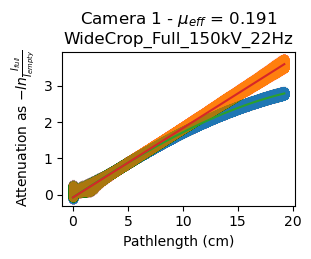

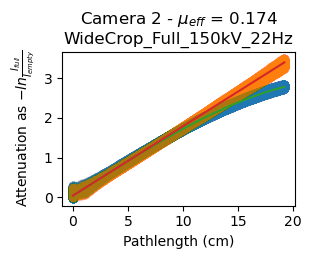

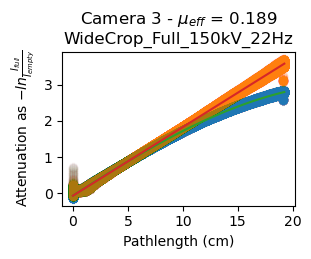

In [36]:
img_path_base = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper')
startline = 0
ROI = [450, 1100]

for cam in cameras:
    path_full = img_path_base / f'03_scattercorrected/WideCrop_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'03_scattercorrected/WideCrop_Empty_150kV_22Hz/camera {cam+1}'
    img_full = singlecam_mean(path_full, framerange, img_shape)
    img_empty = singlecam_mean(path_empty, framerange, img_shape)
    d, _ = calc_distances(geoms_all_cams, cam, det)
    # img_meas = singlecam_mean(meas_path_cam, framerange, img_shape)
    
    # As we are interested in the fit of the part with no internals, focus there
    img_full = img_full[ROI[0]:ROI[1], :]
    img_empty = img_empty[ROI[0]:ROI[1], :]
    d = d[startline + ROI[0] : startline + ROI[1], :]

    coeff, mu_eff, offset = beam_hardening_coefficients(d, img_full, img_empty)

    # Perform beam hardening correction
    img_full_BHC = BHC(img_full, img_empty, coeff, mu_eff, offset)
    img_empty_BHC = BHC(img_empty, img_empty, coeff, mu_eff, offset)
    rel_intensity_BHC = (img_full_BHC / img_empty_BHC).flatten()
    mask_BHC = rel_intensity_BHC > 0
    rel_intensity_log_BHC = -np.log(rel_intensity_BHC[mask_BHC])
    
    rel_intensity_BH = (img_full / img_empty).flatten()
    mask_BH = rel_intensity_BH > 0
    rel_intensity_log_BH = -np.log(rel_intensity_BH[mask_BH])

    d = d.flatten()
    # Plot the results
    d_vals = np.linspace(0, d.max(), 100)
    p_fit = np.polyval(coeff, d_vals)

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.plot(d[mask_BH], rel_intensity_log_BH, 'o', alpha=0.01, label='data')
    ax.plot(d[mask_BHC], rel_intensity_log_BHC, 'o', alpha=0.01, label='data-BHC')
    ax.plot(d_vals, p_fit, label='polyfit')
    ax.plot(d_vals, d_vals*mu_eff + offset, label='constant attenuation')
    ax.set_title(
        f"Camera {cam+1}"
        R" - $\mu_{eff}$ = "
        f"{mu_eff:.3f}\n"
        f"{path_full.parent.name}"
    )
    ax.set_ylabel(r"Attenuation as $-ln\frac{I_{full}}{I_{empty}}$")
    ax.set_xlabel("Pathlength (cm)")
    # ax.legend()

Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\Dark_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Full_150kV_22Hz\camera 1
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Empty_150kV_22Hz\camera 1
original:  y = 0.11.x
offsetted: y = 0.18.x + -0.23
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\Dark_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Full_150kV_22Hz\camera 2
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Empty_150kV_22Hz\camera 2
original:  y = 0.13.x
offsetted: y = 0.16.x + -0.13
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\Dark_22Hz\camera 3


C:\Users\rikvolger\AppData\Local\Temp\ipykernel_5712\4140854075.py:29: RuntimeWarning: invalid value encountered in divide
  rel_intensity_BH = (img_full / img_empty).flatten()


Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Full_150kV_22Hz\camera 3
Reading u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\02_preprocessed\1500x1500Crop_Empty_150kV_22Hz\camera 3
original:  y = 0.12.x
offsetted: y = 0.18.x + -0.20


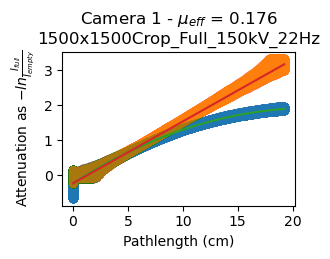

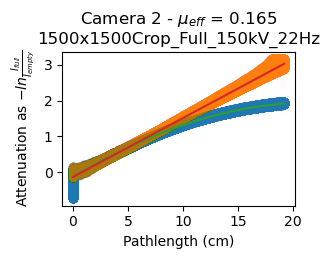

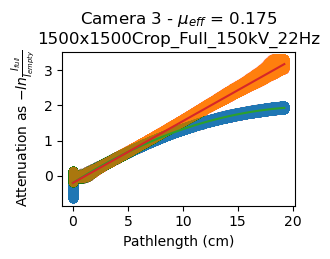

In [9]:
img_path_base = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik')
startline = 0
ROI = [450, 1100]

for cam in cameras:
    path_full = img_path_base / f'02_preprocessed/1500x1500Crop_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'02_preprocessed/1500x1500Crop_Empty_150kV_22Hz/camera {cam+1}'
    path_dark = img_path_base / f'02_preprocessed/Dark_22Hz/camera {cam+1}'
    img_dark = singlecam_mean(path_dark, range(50, 200), img_shape)
    img_full = singlecam_mean(path_full, range(50, 250), img_shape, img_dark)
    img_empty = singlecam_mean(path_empty, range(50, 250), img_shape, img_dark)
    d, _ = calc_distances(geoms_all_cams, cam, det)
    # img_meas = singlecam_mean(meas_path_cam, framerange, img_shape)
    
    # As we are interested in the fit of the part with no internals, focus there
    img_full = img_full[ROI[0]:ROI[1], :]
    img_empty = img_empty[ROI[0]:ROI[1], :]
    d = d[startline + ROI[0] : startline + ROI[1], :]

    coeff, mu_eff, offset = beam_hardening_coefficients(d, img_full, img_empty)

    # Perform beam hardening correction
    img_full_BHC = BHC(img_full, img_empty, coeff, mu_eff, offset)
    img_empty_BHC = BHC(img_empty, img_empty, coeff, mu_eff, offset)
    rel_intensity_BHC = (img_full_BHC / img_empty_BHC).flatten()
    mask_BHC = rel_intensity_BHC > 0
    rel_intensity_log_BHC = -np.log(rel_intensity_BHC[mask_BHC])
    
    rel_intensity_BH = (img_full / img_empty).flatten()
    mask_BH = rel_intensity_BH > 0
    rel_intensity_log_BH = -np.log(rel_intensity_BH[mask_BH])

    d = d.flatten()
    # Plot the results
    d_vals = np.linspace(0, d.max(), 100)
    p_fit = np.polyval(coeff, d_vals)

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.plot(d[mask_BH], rel_intensity_log_BH, 'o', alpha=0.01, label='data')
    ax.plot(d[mask_BHC], rel_intensity_log_BHC, 'o', alpha=0.01, label='data-BHC')
    ax.plot(d_vals, p_fit, label='polyfit')
    ax.plot(d_vals, d_vals*mu_eff + offset, label='constant attenuation')
    ax.set_title(
        f"Camera {cam+1}"
        R" - $\mu_{eff}$ = "
        f"{mu_eff:.3f}\n"
        f"{path_full.parent.name}"
    )
    ax.set_ylabel(r"Attenuation as $-ln\frac{I_{full}}{I_{empty}}$")
    ax.set_xlabel("Pathlength (cm)")
    # ax.legend()

In [37]:
for cam in cameras:
    path_full = img_path_base / f'02_preprocessed/1500x1500_Full_150kV_22Hz/camera {cam+1}'
    path_empty = img_path_base / f'02_preprocessed/1500x1500_Empty_150kV_22Hz/camera {cam+1}'
    coeff, mu_eff = get_coefficients(det, framerange, img_shape, ROI,
                                        geoms_all_cams, cam, path_full,
                                        path_empty)
    bhc_coefficients = {
        'mu_eff': mu_eff,
        'poly_coefficients': coeff
    }
    output_path = img_path_base / '00_calib'
    output_file = output_path / f'bhc_coefficients_cam{cam+1}.yaml'
    with open(output_file, 'w') as outfile:
        yaml.dump(bhc_coefficients, outfile, default_flow_style=False)

NameError: name 'get_coefficients' is not defined